# CMAP - evaluation of phenotypic metrics.

Copyright © The University of Edinburgh, 2022.

Development has been supported by GSK.

## Introduction

CRISPR (xpr) repeats present in the CMAP dataset offer the possibility to evaluate phenotypic metrics applied to different representations of the level 5 L1000 profiles within the CMAP dataset.  Here, we evaluate metric-feature space pairs and their ability to correctly rank xpr repeats as highly similar to each other.  metric and feature space pairs are scored through evaluation of the area under receiver operating characteristic (AUROC), with 0.5 representative of random guessing, 1, perfect performance, and 0 representative of perfectly incorrect ranking being applied to xpr repeats.

We therefore use the CMAP dataloader, extract the A549.311 cell line and perform the evaluation of the following phenotypic metrics:
- Euclidean distance
- Manhattan/cityblock distance
- Cosine similarity
- Scalar projection

We evaluate these on:
- Full feature space
- Standard Scalar feature space
- PCA feature space
- t-SNE feature space
- UMAP feature space.

t-SNE and UMAP are unsuitable for the application of the cosine similarity and scalar projection, being angular metrics and are not applied.

---

First, use the Phenonaut CMAP dataloader to load the entire CMAP dataset.

Process it, extracting the A549.311 cell line where treatment is xpr peturbation or ctl_untrt

Once processed, save it in a pickle so that it can more quickly be loaded in the future. As a "standard scaler" feature space is required for input to PCA, UMAP and t-SNE, we generate standard scalar dataset.  Next, we define the similarity metrics and scoring function.
Be sure to point *BASE_PROJECT_DIR* to a convenient location on the filesystem to write output files.

In [1]:
import numpy as np
import pandas as pd
import phenonaut, phenonaut.transforms
from pathlib import Path
BASE_PROJECT_DIR=Path("projects/cmap")
if not BASE_PROJECT_DIR.exists():
    BASE_PROJECT_DIR.mkdir(parents=True)
phe_object_path=BASE_PROJECT_DIR/"phe_ob_cmap_trt_xpr_A549.311.pickle.gz"
if not phe_object_path.exists():
    cmap_data=phenonaut.packaged_datasets.CMAP("/local_scratch/data/phenonaut_datasets/cmap")
    phe=phenonaut.Phenonaut(cmap_data['ds'])

    phe.new_dataset_from_query("xpr", "cell_id=='A549.311' and (pert_type=='trt_xpr' or pert_type=='ctl_untrt')", "cmap")
    phe['xpr'].perturbation_column="pert_iname"
    phe.save(phe_object_path)
phe=phenonaut.Phenonaut.load(phe_object_path)
phe.clone_dataset("xpr", "xpr_scaled",overwrite_existing=True)
phenonaut.transforms.StandardScaler()(phe['xpr_scaled'])
from scipy.spatial.distance import cosine as cosine_distance
from dataclasses import dataclass
from typing import Union, Callable


@dataclass
class PhenotypicMetric:
    name: str
    func: Union[str, Callable]
    lower_is_better: bool = True
    is_angular: bool = False
metrics = [
    PhenotypicMetric("random", lambda x, y: np.random.uniform(0, 1)),
    PhenotypicMetric("euclidean", "euclidean"),
    PhenotypicMetric("Manhattan", "cityblock"),
    PhenotypicMetric("cosine similarity", lambda x, y: 1 - cosine_distance(x, y), lower_is_better = False, is_angular=True),
    PhenotypicMetric("scalar projection", phenonaut.metrics.measures._scalar_projection_scaled, lower_is_better = False, is_angular=True),
]
metrics_dictionary = {m.name: m for m in metrics}

from sklearn.metrics import roc_auc_score
def auroc_scores_for_perturbation_repeats(ds:phenonaut.data.Dataset, metric:PhenotypicMetric, average_repeats:bool=True)->tuple:
    pert_scores=[]
    df_dict = {"score": [], "perturbation": []}
    dist_mat = ds.distance_df(
        ds,
        metric=metric.func,
        lower_is_better=metric.lower_is_better,
    ).values
    for pert_name in ds.df[ds.perturbation_column].unique():
        pert_indexes = [ds.df.index.get_loc(idx) for idx in ds.df.query(f"pert_iname == '{pert_name}'").index]
        repeat_scores = []
        if metric.lower_is_better:
            for pert_index in pert_indexes:
                predictions = np.zeros(dist_mat.shape[1], dtype=int)
                predictions[pert_indexes] = 1
                prediction_score = -dist_mat[pert_index, :]
                rocscore = roc_auc_score(predictions, prediction_score)
                repeat_scores.append(rocscore)
        else:
            for pert_index in pert_indexes:
                predictions = np.zeros(dist_mat.shape[1], dtype=int)
                predictions[pert_indexes] = 1
                prediction_score = dist_mat[pert_index, :]
                rocscore = roc_auc_score(predictions, prediction_score)
                repeat_scores.append(rocscore)
        if average_repeats:
            df_dict['score'].append(np.mean(repeat_scores))
            df_dict['perturbation'].append(pert_name)
        else:
            df_dict['score'].extend(repeat_scores)
            df_dict['perturbation'].extend([pert_name]*len(repeat_scores))
        pert_scores.append(np.mean(repeat_scores))
    return pert_scores, pd.DataFrame(df_dict)

Generate PCA, UMAP, t-SNE using the standard scalar feature space. ndims = 2 at this stage so we can obtain a unoptimized baseline.

In [2]:
from phenonaut.transforms.dimensionality_reduction import PCA,TSNE,UMAP
NUM_DIMENSIONS=2
phe.clone_dataset("xpr", "xpr_scaled",overwrite_existing=True)
phenonaut.transforms.StandardScaler()(phe['xpr_scaled'])
phe.clone_dataset("xpr_scaled", "xpr_scaled_pca",overwrite_existing=True)
phe.clone_dataset("xpr_scaled", "xpr_scaled_umap",overwrite_existing=True)
phe.clone_dataset("xpr_scaled", "xpr_scaled_tsne",overwrite_existing=True)
pca=PCA()

# Centering on the untreated samples is a good way to place untreated at origin of new reduced feature space.
# Set to None to not perform the recentring.
center_on_perturbation="UnTrt"
pca(phe["xpr_scaled_pca"], ndims=NUM_DIMENSIONS,center_on_perturbation_id=center_on_perturbation, explain_variance_in_features=True)
TSNE()(phe["xpr_scaled_tsne"],ndims=NUM_DIMENSIONS,center_on_perturbation_id=center_on_perturbation)
UMAP()(phe["xpr_scaled_umap"],ndims=NUM_DIMENSIONS, center_on_perturbation_id=center_on_perturbation)

/home/ss942793/.conda/envs/phenonaut/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ss942793/.conda/envs/phenonaut/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### 2D scatters a selection of Xpr perturbations

PCA

<Figure size 432x288 with 0 Axes>

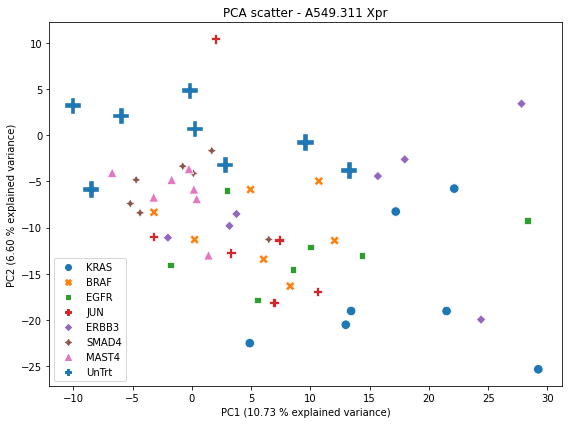

In [4]:
# Handle peculiarity of seaborn used by phenonaut
if 'scatter' in locals():
    del scatter

ds=phe['xpr_scaled_pca']
ds.df.to_csv("FigS6.csv")
scatter=phenonaut.output.Scatter(title="PCA scatter - A549.311 Xpr")
scatter.add(ds, marker_size=90,perturbations=['BRAF', 'EGFR', 'ERBB3', 'JUN', 'KRAS', 'SMAD4', 'MAST4'])
scatter.add(ds, marker_size=300,perturbations=['UnTrt'], markers="P")
scatter._decorate_figure()
scatter.save_figure(BASE_PROJECT_DIR/"pca_scatter.png", dpi=300)
scatter.save_figure("FigS6.png", dpi=300)

UMAP

<Figure size 432x288 with 0 Axes>

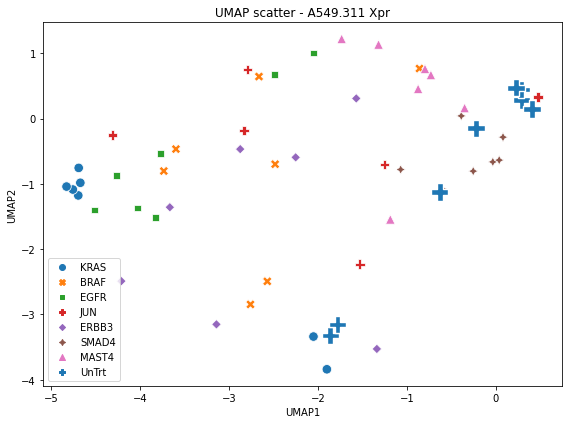

In [5]:
# Handle peculiarity of seaborn used by phenonaut
if 'scatter' in locals():
    del scatter
scatter=phenonaut.output.Scatter(title="UMAP scatter - A549.311 Xpr")
ds=phe['xpr_scaled_umap']
ds.df.to_csv("FigS7.csv")
scatter.add(ds, marker_size=90,perturbations=['BRAF', 'EGFR', 'ERBB3', 'JUN', 'KRAS', 'SMAD4', 'MAST4'])
scatter.add(ds, marker_size=300,perturbations=['UnTrt'], markers="P")
scatter._decorate_figure()
scatter.save_figure(BASE_PROJECT_DIR/"umap_scatter.png", dpi=300)
scatter.save_figure("FigS7.png", dpi=300)

t-SNE

<Figure size 432x288 with 0 Axes>

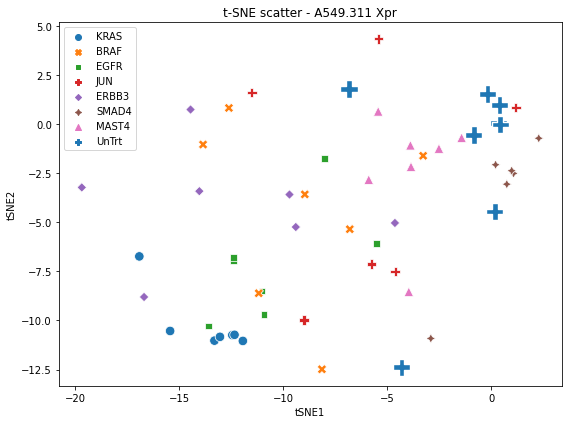

In [6]:
# Handle peculiarity of seaborn used by phenonaut
if 'scatter' in locals():
    del scatter
scatter=phenonaut.output.Scatter(title="t-SNE scatter - A549.311 Xpr")
ds=phe['xpr_scaled_tsne']
ds.df.to_csv("FigS8.csv")
scatter.add(ds, marker_size=90,perturbations=['BRAF', 'EGFR', 'ERBB3', 'JUN', 'KRAS', 'SMAD4', 'MAST4'])
scatter.add(ds, marker_size=300,perturbations=['UnTrt'], markers="P")
scatter._decorate_figure()
scatter.save_figure(BASE_PROJECT_DIR/"tsne_scatter.png", dpi=300)
scatter.save_figure("FigS8.png", dpi=300)

### Score metrics across feature spaces

Evaluate average metric-feature space performance per crispr repeat with an AUROC score and write DataFrame to "metric_scores.csv" in the given project directory.

In [ ]:
if (BASE_PROJECT_DIR/"metric_scores.csv").exists():
    raise FileExistsError(f"{BASE_PROJECT_DIR}/metric_scores.csv exists")

perturbation_scores_df=pd.DataFrame()
for features_name, ds_name in zip(
    ("Full", "Std", "PCA", "UMAP", "t-SNE"),
    ("xpr", "xpr_scaled", "xpr_scaled_pca", "xpr_scaled_umap", "xpr_scaled_tsne"),
):
    print(f"Working on {features_name}")
    for metric in metrics:
        if metric.is_angular and features_name in ['UMAP','t-SNE']:
            continue
        print(f"{metric.name=}")
        scores, feature_metric_df=auroc_scores_for_perturbation_repeats(phe[ds_name],metric)
        feature_metric_df["metric_name"]=metric.name
        feature_metric_df["features"]=features_name
        perturbation_scores_df=pd.concat([perturbation_scores_df, feature_metric_df]).reset_index(drop=True)
perturbation_scores_df.to_csv(BASE_PROJECT_DIR/"metric_scores.csv")

Generate a boxplot of average xpr repeat AUROC score

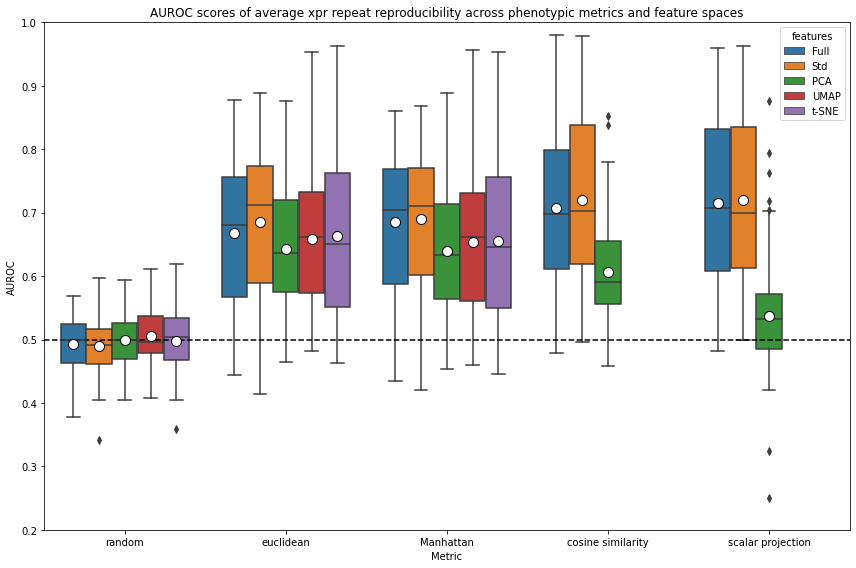

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

metric_scores_df=pd.read_csv(BASE_PROJECT_DIR/"metric_scores.csv")

fig, ax = plt.subplots(1, facecolor='w')
# the size of A4 paper
fig.set_size_inches(12.0, 8)
sns.boxplot(
    data=metric_scores_df,
    y="score",
    x="metric_name",
    hue="features",
    ax=ax,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": "10"},
)
ax.axhline(0.5, color="black", linestyle="--")
ax.set(ylim=(0.2,1), xlabel='Metric', ylabel='AUROC', title="AUROC scores of average xpr repeat reproducibility across phenotypic metrics and feature spaces")

plt.tight_layout()
fig.savefig(BASE_PROJECT_DIR/"boxplot.png", dpi=300)
fig.savefig("FigS9.png", dpi=300)


The above boxplot gives us an idea of metric-featurespace performance, but statistically testing all distributions against the others will allow us to recommend a metric-featurespace pair.  For this, we use the Mann-Whitney U rank test in a 1-tailed mode, testing the alternative hypothesis that a distribution is stochastically greater than the other. 

Once calculated write 2 heatmaps.:
1. A NxN heatmap, where N is all metric-feature space combinations. Values denote p-values that the metric-feature space combination is a given row is performed better than the metric-feature space column given in the column by chance along.  If this value is <0.05, we deem there to be a less than 5 % chance that the metric-feature space combination outperformed the other by chance.
2. A heatmap generated through counting the number of times a p-value of <0.05 was found in a row. This gives at-a-glance information on the number of times a metric-feature space combination outperformed others.

In [11]:
metric_scores_df=pd.read_csv(BASE_PROJECT_DIR/"metric_scores.csv")
@dataclass
class FeatureSpaceAndMetric():
    featurespace:str
    metric:PhenotypicMetric
from scipy.stats import mannwhitneyu
featurespeace_metric_combinations=[FeatureSpaceAndMetric(feature_space, metric) for feature_space in ("Full", "Std", "PCA", "UMAP", "t-SNE") for metric in [m for m in metrics if m.name !="random"] if not (metric.is_angular and feature_space in ['UMAP', 't-SNE'])]

pvals=np.full((len(featurespeace_metric_combinations), len(featurespeace_metric_combinations)),np.nan)

for i1, fsm1 in enumerate(featurespeace_metric_combinations):
    for i2, fsm2 in enumerate(featurespeace_metric_combinations):
        vals1=metric_scores_df.query(f"features=='{fsm1.featurespace}' and metric_name=='{fsm1.metric.name}'")['score'].values
        vals2=metric_scores_df.query(f"features=='{fsm2.featurespace}' and metric_name=='{fsm2.metric.name}'")['score'].values
        pvals[i1, i2]=mannwhitneyu(vals1, vals2,alternative="greater").pvalue
mwu_df=pd.DataFrame(data=pvals, columns=[f"{fsm.featurespace} {fsm.metric.name}" for fsm in featurespeace_metric_combinations], index=[f"{fsm.featurespace} {fsm.metric.name}" for fsm in featurespeace_metric_combinations])
mwu_df.to_csv("FigS10.csv")
from phenonaut.output import write_heatmap_from_df
write_heatmap_from_df(mwu_df,"1-tailed (greater) Mann-Whitney U tests. P values for query metric-features pair AUROC scores being the same or less than candidate metric-features pair AUROC scores", BASE_PROJECT_DIR/"mwu-heatmap.png", figsize=(20,16), lower_is_better=True, highlight_best=False, put_cbar_on_left=True, axis_labels=("Candidate metric-features pair A", "Query metric-features pair"))
write_heatmap_from_df(mwu_df,"1-tailed (greater) Mann-Whitney U tests. P values for query metric-features pair AUROC scores being the same or less than candidate metric-features pair AUROC scores", "FigS10.png", figsize=(20,16), lower_is_better=True, highlight_best=False, put_cbar_on_left=True, axis_labels=("Candidate metric-features pair A", "Query metric-features pair"))
better_than_count=np.sum(pvals[:]<0.05,axis=1)
better_than_count=np.insert(better_than_count,-2, [0,0])
better_than_count=np.insert(better_than_count,better_than_count.shape[0], [0,0]).reshape(5,4)
better_than_df=pd.DataFrame(data=better_than_count, index=("Full", "Std", "PCA", "UMAP", "t-SNE"), columns=[m.name for m in metrics if m.name !="random"])
custom_annotation=better_than_df.copy()
better_than_df.to_csv("FigS11.csv")
custom_annotation.loc[['UMAP','t-SNE'], ['scalar projection', 'cosine similarity']]="NA"
write_heatmap_from_df(better_than_df,"Num significant at 0.05 level", BASE_PROJECT_DIR/"mwu-betterthan-heatmap.png", figsize=(5,4), lower_is_better=False, annotation_format_string_value="g", annot=custom_annotation.transpose().values, sns_colour_palette="Blues")
write_heatmap_from_df(better_than_df,"Num significant at 0.05 level", "FigS11.png", figsize=(5,4), lower_is_better=False, annotation_format_string_value="g", annot=custom_annotation.transpose().values, sns_colour_palette="Blues")

Next, we create boxplot profiles which are usful in identifying individual CRISPR perturbations which are well predicted or the opposite.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
if 'perturbation_scores_df' not in locals():
    perturbation_scores_df=pd.read_csv(BASE_PROJECT_DIR/"metric_scores.csv")
for feature in ("Full", "Std", "PCA", "UMAP", "t-SNE"):

    fig, ax = plt.subplots(len([m for m in metrics if not (m.is_angular and feature in ['UMAP', "t-SNE"])]))
    fig.set_size_inches(31., 14.5)
    for metric, axis in zip([m for m in metrics if not (m.is_angular and feature in ['UMAP', "t-SNE"])], ax):
        sns.boxplot(data=perturbation_scores_df.sort_values("score", ascending=False).query(f"metric_name=='{metric.name}' and features == '{feature}'"),y="score", x="perturbation", ax=axis).set_title(metric.name)
        axis.axhline(0.5, color="black", linestyle="--")
        axis.tick_params(axis='x', rotation=30)
        axis.yaxis.grid(True) # Hide the horizontal gridlines
        axis.set(ylim=(0, 1))
    plt.tight_layout()

    fig.savefig(BASE_PROJECT_DIR/f"xpr_boxplots_{feature}.png", dpi=100)
    fig.clear()

Optuna optimisation of PCA, t-SNE and UMAP ndims

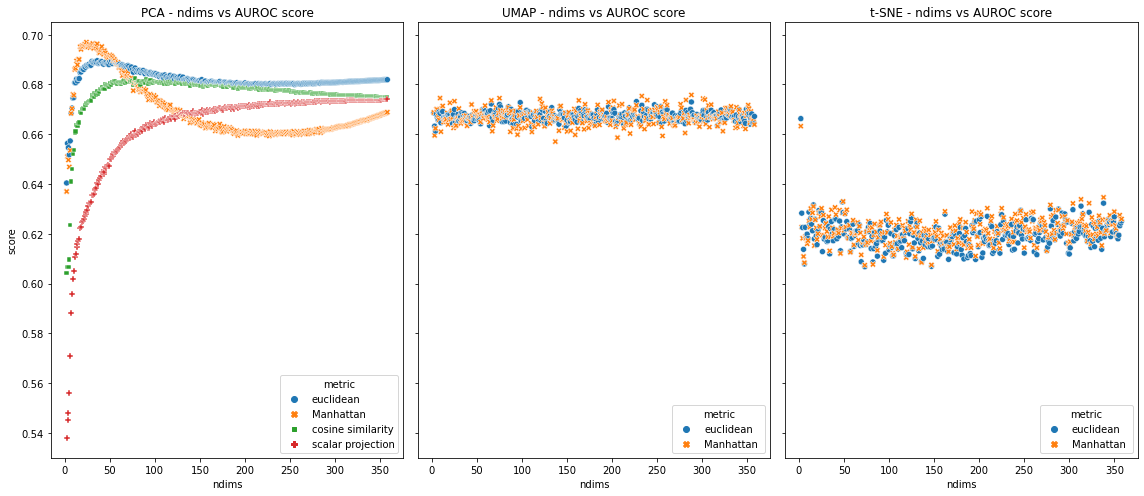

In [12]:
from dataclasses import dataclass
from phenonaut.transforms.dimensionality_reduction import PCA,TSNE,UMAP
from typing import Union, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum, auto
ndims_scan_csv_file=BASE_PROJECT_DIR/"res_ndims_scan.csv"

if not ndims_scan_csv_file.exists():

    def eval_all_metrics(sds, num_dimensions):
        print(f"{num_dimensions=}")
        center_on_perturbation = "UnTrt"
        pca_ds=sds.copy()
        PCA()(pca_ds, ndims=num_dimensions, center_on_perturbation_id=center_on_perturbation)
        tsne_ds=sds.copy()
        TSNE()(tsne_ds, ndims=num_dimensions, center_on_perturbation_id=center_on_perturbation)
        umap_ds=sds.copy()
        UMAP()(umap_ds, ndims=num_dimensions, center_on_perturbation_id=center_on_perturbation)
        results=np.empty((len([m for m in metrics if m.name != "random"]), 3))

        for i, metric in enumerate([m for m in metrics if m.name != "random"]):
            for j, (ds, angular_is_ok) in enumerate(((pca_ds, True), (tsne_ds, False), (umap_ds, False))):
                if not metric.is_angular or (metric.is_angular and angular_is_ok):
                    auroc_scores, _ = auroc_scores_for_perturbation_repeats(ds,metric)
                    results[i,j]=np.mean(auroc_scores)
                else:
                    results[i,j]=np.nan
        return results
    
    from multiprocessing import Pool


        
    sds = phe["xpr_scaled"].copy()

    n_dims_list = np.arange(2, min(sds.df.shape[0]-2, sds.df.shape[1]-2))
    print(f"{len(n_dims_list)=}")
    # [PCA, tSNE, UMAP], metric, dimensions
    pool = Pool()
    res = np.array(pool.starmap(eval_all_metrics, ((sds, nd) for nd in n_dims_list)))
    pool.close() # Make sure to close the pool (wait for completion)

    df_metric_list=[]
    df_features_list=[]
    df_ndims_list=[]
    df_score_list=[]

    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            for k in range(res.shape[2]):
                print(i,j,k)
                df_ndims_list.append(i+2)
                df_metric_list.append([m for m in metrics if m.name != "random"][j].name)
                df_features_list.append(["PCA", "tSNE", "UMAP"][k])
                df_score_list.append(res[i,j,k])

    import pandas as pd
    pd.DataFrame({"metric":df_metric_list, "features":df_features_list, "ndims":df_ndims_list, "score":df_score_list}).to_csv(ndims_scan_csv_file)
# CSV file exists or has been generated above
ndims_df=pd.read_csv(ndims_scan_csv_file)

fig, ax=plt.subplots(1,3, figsize=(16,7), sharey=True)
sns.scatterplot(data=ndims_df.query('features=="PCA"'), x='ndims', y="score", style='metric', hue='metric', ax=ax[0], legend=True)
ax[0].title.set_text('PCA - ndims vs AUROC score')
sns.scatterplot(data=ndims_df.query('features=="UMAP" and metric!="cosine similarity" and metric!="scalar projection"'), x='ndims', y="score", style='metric', hue='metric', ax=ax[1], legend=True)
ax[1].title.set_text('UMAP - ndims vs AUROC score')
sns.scatterplot(data=ndims_df.query('features=="tSNE" and metric!="cosine similarity" and metric!="scalar projection"'), x='ndims', y="score", style='metric', hue='metric', ax=ax[2],legend=True)
ax[2].title.set_text('t-SNE - ndims vs AUROC score')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
for axis in ax: sns.move_legend(axis, "lower right")
plt.tight_layout()
fig.savefig(BASE_PROJECT_DIR/"ndims_optimisation_scatter.png", dpi=300)


Using the best identified ndims from above, we may create feature spaces tuned to each metric and evaluate performance of this ndim optimized feature space.

In [ ]:
metric_scores = {"metric_name": [], "score": [], "features": []}
metrics_dict = {m.name: m for m in metrics}
perturbation_scores_ndim_opt=pd.DataFrame()

print(metrics_dict)
ds_pca_36 = phe["xpr_scaled3"].copy()
PCA()(ds_pca_36, ndims=36, center_on_perturbation_id=center_on_perturbation)
ds_pca_24 = phe["xpr_scaled"].copy()
PCA()(ds_pca_24, ndims=24, center_on_perturbation_id=center_on_perturbation)
ds_pca_78 = phe["xpr_scaled"].copy()
PCA()(ds_pca_78, ndims=78, center_on_perturbation_id=center_on_perturbation)
ds_pca_356 = phe["xpr_scaled"].copy()
PCA()(ds_pca_356, ndims=356, center_on_perturbation_id=center_on_perturbation)

ds_tsne_2 = phe["xpr_scaled"].copy()
TSNE()(ds_tsne_2, ndims=2)

ds_umap_227 = phe["xpr_scaled"].copy()
UMAP()(ds_umap_227, ndims=227)
ds_umap_288 = phe["xpr_scaled"].copy()
UMAP()(ds_umap_288, ndims=288)


for features_name, ds, metric in [
    ("Full", phe["xpr"].copy(), metrics_dict["random"]),
    ("Std", phe["xpr_scaled"].copy(), metrics_dict["random"]),
    ("PCA", ds_pca_24, metrics_dict["random"]),
    ("UMAP", ds_umap_227, metrics_dict["random"]),
    ("t-SNE", ds_tsne_2, metrics_dict["random"]),
    ("Full", phe["xpr"].copy(), metrics_dict["euclidean"]),
    ("Std", phe["xpr_scaled"].copy(), metrics_dict["euclidean"]),
    ("PCA", ds_pca_36, metrics_dict["euclidean"]),
    ("UMAP", ds_umap_227, metrics_dict["euclidean"]),
    ("t-SNE", ds_tsne_2, metrics_dict["euclidean"]),
    ("Full", phe["xpr"].copy(), metrics_dict["Manhattan"]),
    ("Std", phe["xpr_scaled"].copy(), metrics_dict["Manhattan"]),
    ("PCA", ds_pca_24, metrics_dict["Manhattan"]),
    ("UMAP", ds_umap_288, metrics_dict["Manhattan"]),
    ("t-SNE", ds_tsne_2, metrics_dict["Manhattan"]),
    ("Full", phe["xpr"].copy(), metrics_dict["cosine similarity"]),
    ("Std", phe["xpr_scaled"].copy(), metrics_dict["cosine similarity"]),
    ("PCA", ds_pca_78, metrics_dict["cosine similarity"]),
    ("Full", phe["xpr"].copy(), metrics_dict["scalar projection"]),
    ("Std", phe["xpr_scaled"].copy(), metrics_dict["scalar projection"]),
    ("PCA", ds_pca_356, metrics_dict["scalar projection"]),
]:
    print(f"Working on {features_name}")
    scores, feature_metric_df=auroc_scores_for_perturbation_repeats(ds,metric)
    feature_metric_df["metric_name"]=metric.name
    feature_metric_df["features"]=features_name
    perturbation_scores_ndim_opt=pd.concat([perturbation_scores_ndim_opt, feature_metric_df]).reset_index(drop=True)

perturbation_scores_ndim_opt.to_csv(BASE_PROJECT_DIR / "optimised_perturbation_scores_ndim_opt.csv")


As before, generate boxplots of ndims optimized metric-feature spaces

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv(BASE_PROJECT_DIR / "optimised_perturbation_scores_ndim_opt.csv")

# data['score']=data['score'].clip(upper=12000)
fig, ax = plt.subplots(1, facecolor='w')
# the size of A4 paper
fig.set_size_inches(12.0, 8)
sns.boxplot(
    data=data,
    y="score",
    x="metric_name",
    hue="features",
    ax=ax,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": "10"},
)
ax.axhline(0.5, color="black", linestyle="--")
data.to_csv(BASE_PROJECT_DIR/"scores.csv")
ax.set(ylim=(0.2,1), xlabel='Metric', ylabel='AUROC')
plt.tight_layout()
fig.savefig(BASE_PROJECT_DIR/"boxplot_opt.png", dpi=300)
fig.savefig("S13.png", dpi=300)

In [ ]:
from scipy.stats import mannwhitneyu

optimised_perturbation_scores_df=pd.read_csv(BASE_PROJECT_DIR/"optimised_perturbation_scores.csv")
@dataclass
class FeatureSpaceAndMetric():
    featurespace:str
    metric:PhenotypicMetric
from scipy.stats import mannwhitneyu
featurespeace_metric_combinations=[FeatureSpaceAndMetric(feature_space, metric) for feature_space in ("Full", "Std", "PCA", "UMAP", "t-SNE") for metric in [m for m in metrics if m.name !="random"] if not (metric.is_angular and feature_space in ['UMAP', 't-SNE'])]

pvals=np.full((len(featurespeace_metric_combinations), len(featurespeace_metric_combinations)),np.nan)

for i1, fsm1 in enumerate(featurespeace_metric_combinations):
    for i2, fsm2 in enumerate(featurespeace_metric_combinations):
        vals1=optimised_perturbation_scores_df.query(f"features=='{fsm1.featurespace}' and metric_name=='{fsm1.metric.name}'")['score'].values
        vals2=optimised_perturbation_scores_df.query(f"features=='{fsm2.featurespace}' and metric_name=='{fsm2.metric.name}'")['score'].values
        pvals[i1, i2]=mannwhitneyu(vals1, vals2,alternative="greater").pvalue
mwu_df=pd.DataFrame(data=pvals, columns=[f"{fsm.featurespace} {fsm.metric.name}" for fsm in featurespeace_metric_combinations], index=[f"{fsm.featurespace} {fsm.metric.name}" for fsm in featurespeace_metric_combinations])
from phenonaut.output import write_heatmap_from_df
#write_heatmap_from_df(mwu_df,"1-tailed (greater) Mann-Whitney U", BASE_PROJECT_DIR/"mwu_heatmap_opt.png", figsize=(20,16), lower_is_better=True, highlight_best=False)
write_heatmap_from_df(mwu_df,"1-tailed (greater) Mann-Whitney U tests. P values for query metric-features pair AUROC scores being the same or less than candidate metric-features pair AUROC scores", BASE_PROJECT_DIR/"mwu-heatmap.png", figsize=(20,16), lower_is_better=True, highlight_best=False, put_cbar_on_left=True, axis_labels=("Candidate metric-features pair", "Query metric-features pair"), sns_colour_palette="Blues")

better_than_count=np.sum(pvals[:]<0.05,axis=1)
better_than_count=np.insert(better_than_count,-2, [0,0])
better_than_count=np.insert(better_than_count,better_than_count.shape[0], [0,0]).reshape(5,4)
better_than_df=pd.DataFrame(data=better_than_count, index=("Full", "Std", "PCA", "UMAP", "t-SNE"), columns=[m.name for m in metrics if m.name !="random"])
custom_annotation=better_than_df.copy()
custom_annotation.loc[['UMAP','t-SNE'], ['scalar projection', 'cosine similarity']]="NA"
write_heatmap_from_df(better_than_df,"Num significant at 0.05 level", BASE_PROJECT_DIR/"betterthan_heatmap_opt.png", figsize=(5,4), lower_is_better=False, annotation_format_string_value="g", annot=custom_annotation.transpose().values, sns_colour_palette="Blues")